## 개요

COVID-19의 확산으로 우리나라는 물론 전 세계 사람들은 경제적, 생산적인 활동에 많은 제약을 가지게 되었습니다. 

우리나라는 COVID-19 확산 방지를 위해 사회적 거리 두기를 단계적으로 시행하는 등의 많은 노력을 하고 있습니다. 

과거 높은 사망률을 가진 사스(SARS)나 에볼라(Ebola)와는 달리 COVID-19의 치사율은 오히려 비교적 낮은 편에 속합니다. 

그럼에도 불구하고, 이렇게 오랜 기간 동안 우리를 괴롭히고 있는 근본적인 이유는 바로 COVID-19의 강력한 전염력 때문입니다.

감염자의 입, 호흡기로부터 나오는 비말, 침 등으로 인해 다른 사람에게 쉽게 전파가 될 수 있기 때문에 감염 확산 방지를 위해 무엇보다 중요한 것은 모든 사람이 마스크로 코와 입을 가려서 혹시 모를 감염자로부터의 전파 경로를 원천 차단하는 것입니다. 

이를 위해 공공 장소에 있는 사람들은 반드시 마스크를 착용해야 할 필요가 있으며, 무엇 보다도 코와 입을 완전히 가릴 수 있도록 올바르게 착용하는 것이 중요합니다. 

하지만 넓은 공공장소에서 모든 사람들의 올바른 마스크 착용 상태를 검사하기 위해서는 추가적인 인적자원이 필요할 것입니다.

따라서, 우리는 카메라로 비춰진 사람 얼굴 이미지 만으로 이 사람이 마스크를 쓰고 있는지, 쓰지 않았는지, 정확히 쓴 것이 맞는지 자동으로 가려낼 수 있는 시스템이 필요합니다. 

이 시스템이 공공장소 입구에 갖춰져 있다면 적은 인적자원으로도 충분히 검사가 가능할 것입니다.

### Import

In [22]:
import matplotlib.pyplot as plt
import plotly
import pandas as pd
import numpy as np
import os
import seaborn as sns
from tabulate import tabulate
import missingno as msno
from IPython.display import display_html
from PIL import Image
import gc
import cv2
from tqdm.notebook import tqdm
from glob import glob

import torchvision

### 데이터 경로 설정

In [3]:
path = '/opt/ml/input/data'

In [4]:
train_df = pd.read_csv(path + '/train/train.csv')
eval_df = pd.read_csv(path + '/eval/info.csv')
print('Train has {:,} rows and Eval has {:,} rows.' .format(len(train_df), len(eval_df)))

Train has 2,700 rows and Eval has 12,600 rows.


### 결측값 찾기

/opt/conda/lib/python3.8/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


Text(0.5, 1.0, 'Eval Missing Values Map')

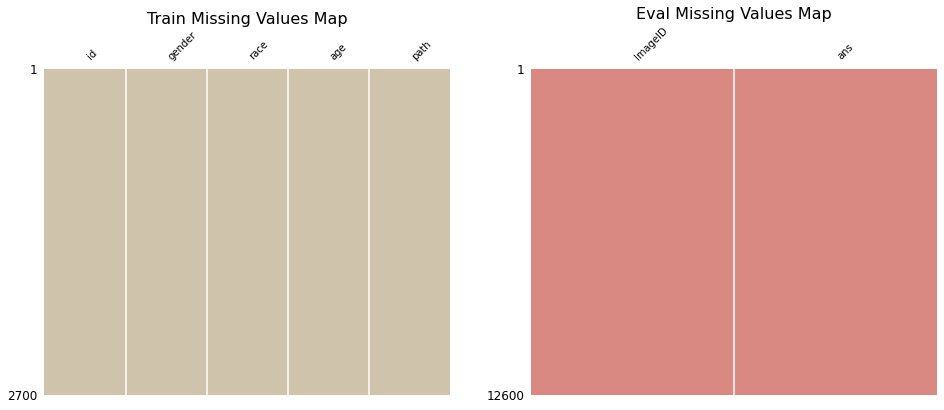

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

msno.matrix(train_df, ax = ax1, color = (207/255, 196/255, 171/255), fontsize = 10)
msno.matrix(eval_df, ax = ax2, color = (218/255, 136/255, 130/255), fontsize = 10)

ax1.set_title('Train Missing Values Map', fontsize = 16)
ax2.set_title('Eval Missing Values Map', fontsize = 16)

### 데이터 feature 살펴보기

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   object
 2   race    2700 non-null   object
 3   age     2700 non-null   int64 
 4   path    2700 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.6+ KB


In [7]:
train_df.describe(include='all')

,id,gender,race,age,path
count,2700,2700,2700,2700.000000,2700
unique,2699,2,1,NaN,2700
top,003397,female,Asian,NaN,003740_female_Asian_50
freq,2,1658,2700,NaN,1
mean,NaN,NaN,NaN,37.708148,NaN
std,NaN,NaN,NaN,16.985904,NaN
min,NaN,NaN,NaN,18.000000,NaN
25%,NaN,NaN,NaN,20.000000,NaN
50%,NaN,NaN,NaN,36.000000,NaN
75%,NaN,NaN,NaN,55.000000,NaN


In [24]:
train_df['age'].describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

In [8]:
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        if col != 'id' and col != 'path':
            categories = train_df[col].unique()
            print(f'[{col}] ({len(categories)})')
            print('\n'.join(categories))
            print()

[gender] (2)
female
male

[race] (1)
Asian



In [9]:
group = train_df.groupby('gender')['age'].value_counts()
display(group)
print(train_df['gender'].value_counts())

gender  age
female  19     200
        20     187
        18     151
        58     109
        60     109
              ... 
male    37       2
        42       2
        36       1
        44       1
        47       1
Name: age, Length: 84, dtype: int64

female    1658
male      1042
Name: gender, dtype: int64


### Bar plot을 활용해 데이터 표현하기

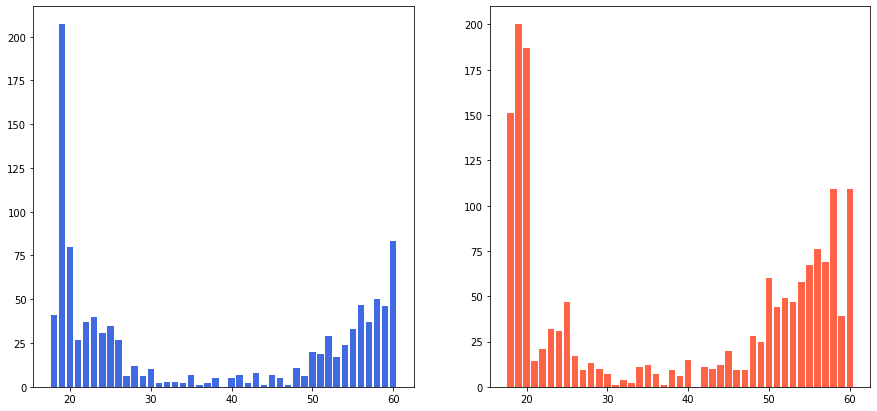

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].bar(group['male'].index, group['male'], color='royalblue')
axes[1].bar(group['female'].index, group['female'], color='tomato')
plt.show()

In [11]:
conditions = [(train_df['age'] < 30), (train_df['age'] >= 30) & (train_df['age'] < 60), (train_df['age'] >= 60)]
values = ['< 30', '>= 30 and < 60', '>= 60']
train_df['age_sec'] = np.select(conditions, values)
train_df.head()

,id,gender,race,age,path,age_sec
0,000001,female,Asian,45,000001_female_Asian_45,>= 30 and < 60
1,000002,female,Asian,52,000002_female_Asian_52,>= 30 and < 60
2,000004,male,Asian,54,000004_male_Asian_54,>= 30 and < 60
3,000005,female,Asian,58,000005_female_Asian_58,>= 30 and < 60
4,000006,female,Asian,59,000006_female_Asian_59,>= 30 and < 60


gender  age_sec       
female  >= 30 and < 60    817
        < 30              732
        >= 60             109
male    < 30              549
        >= 30 and < 60    410
        >= 60              83
Name: age_sec, dtype: int64

female    1658
male      1042
Name: gender, dtype: int64


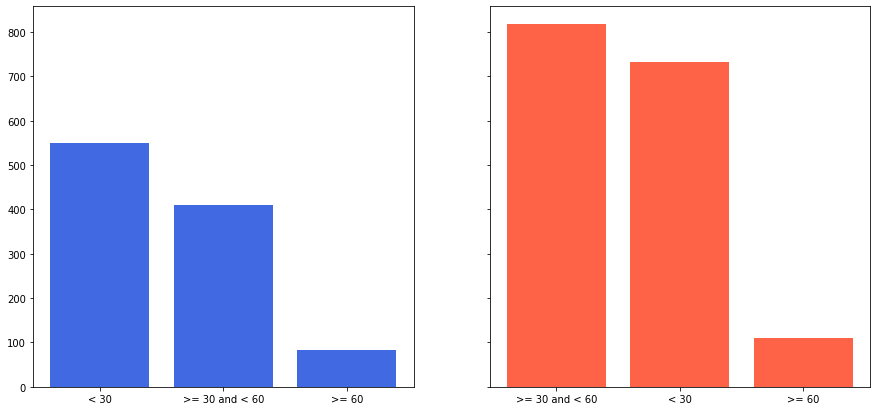

In [12]:
group = train_df.groupby('gender')['age_sec'].value_counts()
display(group)
print(train_df['gender'].value_counts())

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
axes[0].bar(group['male'].index, group['male'], color='royalblue')
axes[1].bar(group['female'].index, group['female'], color='tomato')
plt.show()

### RGB 분석

In [13]:
class cfg:
    data_dir = '학습 이미지 폴더의 경로를 입력해주세요.'  
    img_dir = path + '/train/images'
    df_path = path + '/train/train.csv'

In [14]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [15]:
def get_ext(img_dir, img_id):
    """
    학습 데이터셋 이미지 폴더에는 여러 하위폴더로 구성되고, 이 하위폴더들에는 각 사람의 사진들이 들어가있습니다. 하위폴더에 속한 이미지의 확장자를 구하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름

    Returns:
        ext: 이미지의 확장자
    """
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

In [16]:
def get_img_stats(img_dir, img_ids):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_ids: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [23]:
img_info = get_img_stats(cfg.img_dir, df.path.values[:100])

print(f'Total number of people is {len(df)}')
print(f'Total number of images is {len(df) * 7}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')


Total number of people is 2700
Total number of images is 18900
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 384
Maximum width for dataset is 384
Average width for dataset is 384
RGB Mean: [0.55800916 0.51224077 0.47767341]
RGB Standard Deviation: [0.21817792 0.23804603 0.25183411]


In [31]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [36]:
imgs = []
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir, img_id)
for class_id in num2class:
    img = np.array(cv2.imread(os.path.join(cfg.img_dir, img_id, class_id+ext)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
imgs = np.array(imgs)

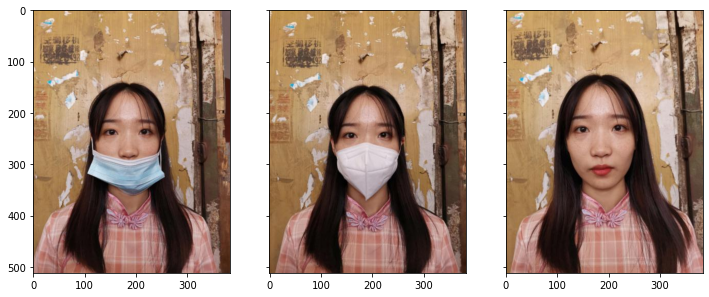

In [37]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 6))
axes[0].imshow(imgs[0])
axes[1].imshow(imgs[1])
axes[2].imshow(imgs[-1])
plt.show()

In [38]:
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir, img_id)

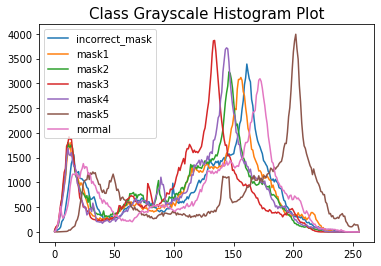

In [39]:
plt.figure()
plt.subplot(111)

for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    sns.lineplot(data=histogram)

plt.legend(num2class)
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

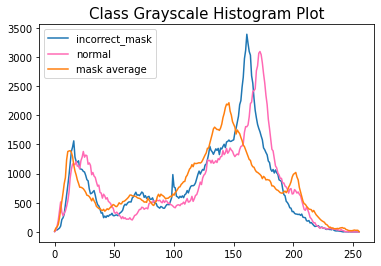

In [40]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'incorrect_mask'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram, color='hotpink')

histograms = []
for i in range(1, 6):
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, num2class[i]+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    histograms.append(histogram)
sns.lineplot(data=np.mean(histograms, axis=0))

plt.legend(['incorrect_mask', 'normal', 'mask average'])
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

No handles with labels found to put in legend.


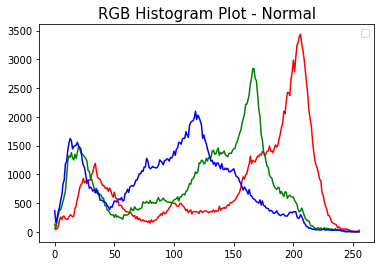

In [41]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)))
colormap = ['red', 'green', 'blue']
for i in range(3):
    histogram, bin_edges = np.histogram(img[..., i], bins=256, range=(0, 255))
    sns.lineplot(data=histogram, color=colormap[i])

plt.legend()
plt.title('RGB Histogram Plot - Normal', fontsize=15)
plt.show()